# Deepfake Evaluation Notebook

This notebook uses functions, classes, and helpers from the repository to perform inference on your own list of audio files using a pretrained deepfake detection model.
  
**Steps:**
1. Import dependencies and define utility functions.
2. Define a custom dataset to load your audio files.
3. Load your list of WAV/FLAC files.
4. Create a DataLoader.
5. Load the pretrained model from the repository and set it to evaluation mode.
6. Run inference and collect detection scores.
7. Visualize the score distribution.

In [1]:
# Optional Cell: Generate WAV file list from directory
import os

def get_audio_files_recursive(
    folder_path,
    formats=('wav', 'flac'),
    exclude_prefix=('.', '__'),
    required_path_segment=None
):
    """
    Recursively find audio files in a directory with specified extensions,
    optionally requiring a specific segment in their path.
    
    Args:
        folder_path (str): Root directory to search.
        formats (tuple): File extensions to include (lowercase).
        exclude_prefix (tuple): Skip directories starting with these prefixes.
        required_path_segment (str, optional): 
            A string that must be part of the file's path.
            Example: '/test/', os.sep + 'test' + os.sep, or 'test_file'.
    
    Returns:
        list: Full paths to audio files.
    """
    valid_files = []
    normalized_segment_for_dir_check = None

    if required_path_segment:
        is_dir_segment = (
            required_path_segment.startswith(os.sep) or
            required_path_segment.endswith(os.sep) or
            os.sep in required_path_segment
        )
        if is_dir_segment:
            normalized_segment_for_dir_check = os.path.normpath(
                required_path_segment
            )
            if not normalized_segment_for_dir_check.startswith(os.sep):
                normalized_segment_for_dir_check = (
                    os.sep + normalized_segment_for_dir_check
                )
            if not normalized_segment_for_dir_check.endswith(os.sep):
                normalized_segment_for_dir_check = (
                    normalized_segment_for_dir_check + os.sep
                )
        else: 
            normalized_segment_for_dir_check = required_path_segment

    for root, dirs, files in os.walk(folder_path):
        dirs[:] = [d for d in dirs if not d.startswith(exclude_prefix)]
        
        for file in files:
            ext = os.path.splitext(file)[1][1:].lower()
            if ext in formats:
                full_path = os.path.join(root, file)
                normalized_full_path = os.path.normpath(full_path)

                if normalized_segment_for_dir_check:
                    if normalized_segment_for_dir_check in normalized_full_path:
                        valid_files.append(full_path)
                else: 
                    valid_files.append(full_path)
                
    return valid_files

input_folder = './data/dataset_sintetico/' # Adjusted path

# --- Configuration for path filtering ---
required_segment_filter = '/test/'
# required_segment_filter = None
# --- End Configuration ---

file_paths = get_audio_files_recursive(
    input_folder,
    formats=('wav', 'flac'),
    required_path_segment=required_segment_filter
)

if file_paths:
    found_formats = sorted(list(set(
        [os.path.splitext(f)[1] for f in file_paths]
    )))
    formats_str = ', '.join(found_formats)
else:
    formats_str = 'N/A'

if required_segment_filter:
    display_filter = (
        required_segment_filter.strip(os.sep)
        if os.sep in required_segment_filter
        else required_segment_filter
    )
    print(
        f"Found {len(file_paths)} audio files with paths containing "
        f"'{display_filter}' ({formats_str} formats)"
    )
else:
    print(
        f"Found {len(file_paths)} audio files "
        f"(no path segment filter applied) ({formats_str} formats)"
    )

Found 76644 audio files (.flac formats)


In [2]:
# Cell 2: Core Imports
import os
import torch
import numpy as np
import soundfile as sf
import json
import sys

In [3]:
# Cell 3: Load Model
import os # already imported, but good for cell isolation
import torch # already imported
import json # already imported
import sys # already imported

# --- Python Path Modification ---
aasist_code_path = '/app/aasist_code'
if aasist_code_path not in sys.path:
    sys.path.insert(0, aasist_code_path)
# --- End Python Path Modification ---

from main import get_model # From /app/aasist_code/main.py

# Load model configuration
config_path = os.path.join(aasist_code_path, "config/AASIST.conf")
with open(config_path, "r") as f_config: # Renamed f to f_config
    config = json.load(f_config)

config["track"] = "DF"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = get_model(config["model_config"], device)

raw_model_path_from_config = config["model_path"]
if not os.path.isabs(raw_model_path_from_config):
    model_path_to_load = os.path.join(aasist_code_path, raw_model_path_from_config)
else:
    model_path_to_load = raw_model_path_from_config

print(f"Loading model weights from: {model_path_to_load}")
model.load_state_dict(torch.load(model_path_to_load, map_location=device))
model = model.to(device)
model.eval()
print("AASIST Model loaded and set to evaluation mode on device:", device)

no. model params:297866
Deepfake Detection model loaded and set to evaluation mode on device: cuda


In [4]:
# Cell 4: Batch Inference and Score Saving
import os # already imported
import torch # already imported
import numpy as np # already imported
import soundfile as sf # already imported
import pickle
import sys # already imported

# --- Python Path Modification (ensure it's there) ---
aasist_code_path = '/app/aasist_code'
if aasist_code_path not in sys.path:
    sys.path.insert(0, aasist_code_path)
# --- End Python Path Modification ---

from data_utils import pad # From /app/aasist_code/data_utils.py
from torch.utils.data import Dataset, DataLoader # Imported here
from tqdm.autonotebook import tqdm

# Parameters
sample_length = 64600
batch_size = 16
num_workers = 4
output_dir = "./outputs/"
pickle_file_name = 'aasist_detection_scores.pkl'
pickle_file_path = os.path.join(output_dir, pickle_file_name)
force_overwrite = True

os.makedirs(output_dir, exist_ok=True)

if os.path.exists(pickle_file_path) and not force_overwrite:
    with open(pickle_file_path, 'rb') as f_pickle_load: # Renamed f
        all_scores = pickle.load(f_pickle_load)
    print(f"Loaded scores from {pickle_file_path}. Skipping inference.")
else:
    all_scores = {}

    class AudioDataset(Dataset):
        def __init__(self, file_list, base_folder, sample_length=64600):
            self.file_list = file_list
            self.base_folder = os.path.normpath(base_folder)
            self.sample_length = sample_length

        def __len__(self):
            return len(self.file_list)

        def __getitem__(self, idx):
            file_path = self.file_list[idx]
            audio, sr = sf.read(file_path)
            if audio.ndim > 1:
                audio = np.mean(audio, axis=1)
            padded_audio = pad(audio, self.sample_length) # Uses imported pad
            audio_tensor = torch.tensor(padded_audio, dtype=torch.float)
            
            norm_file_path = os.path.normpath(file_path)
            if norm_file_path.startswith(self.base_folder):
                rel_path = norm_file_path[len(self.base_folder) + len(os.sep):]
            else:
                rel_path = os.path.basename(file_path)
            return audio_tensor, rel_path

    # input_folder is defined in Cell 1
    dataset = AudioDataset(file_paths, base_folder=input_folder, sample_length=sample_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model.eval()
    for batch_audio, batch_rel_paths in tqdm(dataloader, desc="AASIST Batch inference"):
        batch_audio = batch_audio.to(device)
        with torch.no_grad():
            outputs = model(batch_audio)
            if isinstance(outputs, tuple):
                logits = outputs[1]
            else:
                logits = outputs
            batch_scores_list = logits[:, 1].cpu().numpy().tolist() # Renamed
        
        for rel_path, score_val in zip(batch_rel_paths, batch_scores_list): # Renamed
            all_scores[rel_path] = score_val

        with open(pickle_file_path, 'wb') as f_pickle_save: # Renamed f
            pickle.dump(all_scores, f_pickle_save)
    print(f"AASIST Inference complete. Scores saved to {pickle_file_path}")

Batch inference:   0%|          | 0/2396 [00:00<?, ?it/s]

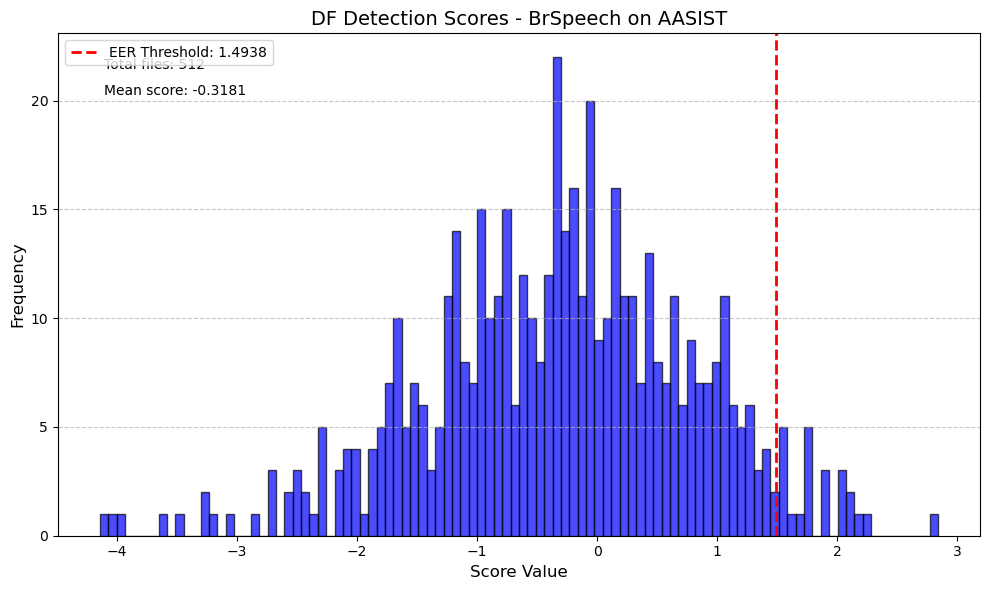

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_scores is a dictionary of your scores
scores = list(all_scores.values())

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(scores, bins=100, alpha=0.7, 
                            color='blue', edgecolor='black')

# EER Threshold value
eer_threshold = 1.493813753

# Add a vertical line for the EER Threshold
plt.axvline(eer_threshold, color='red', linestyle='--', 
            linewidth=2, label=f'EER Threshold: {eer_threshold:.4f}')

plt.title('DF Detection Scores - BrSpeech on AASIST', fontsize=14)
plt.xlabel('Score Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text annotations for total files and mean score
plt.text(0.05, 0.95, f'Total files: {len(scores)}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Mean score: {np.mean(scores):.4f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()
